# Backpropagation Lab





In [1]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.neural_network import MLPClassifier
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from scipy.io import arff
import pandas as pd

## 1. (40%) Correctly implement and submit your own code for the backpropagation algorithm. 

## Code requirements 
- Ability to create a network structure with at least one hidden layer and an arbitrary number of nodes.
- Random weight initialization with small random weights with mean of 0 and a variance of 1.
- Use Stochastic/On-line training updates: Iterate and update weights after each training instance (i.e. do not attempt batch updates)
- Implement a validation set based stopping criterion.
- Shuffle training set at each epoch.
- Option to include a momentum term

You may use your own random train/test split or use the scikit-learn version if you want.

Use your Backpropagation algorithm to solve the Debug data. We provide you with several parameters, and you should be able to replicate our results every time. When you are confident it is correct, run your script on the Evaluation data with the same parameters, and print your final weights.

In [2]:
class MLP(BaseEstimator,ClassifierMixin):

    def __init__(self,lr=.1, momentum=0, shuffle=True,hidden_layer_widths=None, bias=1):
        self.hidden_layer_widths = hidden_layer_widths
        self.lr = lr
        self.momentum = momentum
        self.shuffle = shuffle
        self.bias = bias
        self.DeltaW = None
        self.mse = []
        self.accuracyList = []


    def fit(self, X, y, initial_weights=None, epochs=10, validation_percentage=.15):
        # self.weights = self.initialize_weights(X.shape[1],y.shape[1], initial_weights) if not initial_weights else initial_weights
        Xdim = self.get_dim(X)
        Ydim = self.get_dim(y)
        # Ydim = 2 if self.get_dim(y)==1 else self.get_dim(y)
        self.weights = self.initialize_weights(Xdim,Ydim, initial_weights) 
        self.initialize_delta_weights()

        if not epochs:
            xShuffled, yShuffled = self._shuffle_data(X,y)            
            xTrain, xValid, yTrain, yValid = self.split_data(xShuffled, yShuffled, percentage=validation_percentage)
            # xTrain, xValid, yTrain, yValid = self.split_data(X, y, percentage=validation_percentage)
            accuracy = 0
            accuracyRepeatCount = 0
            while accuracy< 0.95 and accuracyRepeatCount <50 :
                mseOfEpoch = self.epoch(xTrain,yTrain)
                self.mse.append(mseOfEpoch)
                currentAccuracy = self.score(xValid,yValid)
                self.accuracyList.append(currentAccuracy)
                if np.abs(accuracy-currentAccuracy) <= 0.02 : accuracyRepeatCount = accuracyRepeatCount + 1
                accuracy = currentAccuracy
        else:
            for i in range(epochs):
                mseOfEpoch = self.epoch(X,y)
                self.mse.append(mseOfEpoch)
        return self

    def score(self, X, y):
        outputsOrIndexes = self.predict(X, y.ndim)
        accuracyCount = 0
        if y.ndim == 1:
            for output, target in zip(outputsOrIndexes, y):
                if output == target: accuracyCount = accuracyCount + 1
        else:
            for index_, target in zip(outputsOrIndexes, y):
                if target[index_] == 1 : accuracyCount = accuracyCount + 1
        
        return accuracyCount/X.shape[0]

    def predict(self, X, outputDimension):
        if outputDimension==1: #perceptron Logic
            opVector = []
            for x_ in X:
                net, _ = self.forward_pass(x_)
                op = 1 if net>0 else 0
                opVector.append(op)
            return opVector
        else:
            indexes = []
            for x_ in X: #Multi-output classification
                op, _ = self.forward_pass(x_)
                op = op.tolist()
                # index = op.index(max(op))
                index = op.index(max(op))
                indexes.append(index)
            return indexes

    def epoch(self, X, y): 
        mse = 0       
        if self.shuffle == True:
            X, y = self._shuffle_data(X,y)
        
        for i in range(X.shape[0]): 
            mseDataPoint =  self.process_a_data_instance_of_an_epoch(X[i], y[i])
            mse = mse + mseDataPoint
        return mse/X.shape[0]

    def process_a_data_instance_of_an_epoch(self, X, y):
        op, opList = self.forward_pass(X)
        deltaLast = self.delta_last_layer(y,op)
        deltaList = self.delta_full_list(opList, deltaLast)

        mseDataPoint = np.square(op-y).mean()
        
        dwList = list()
        for delta, op in zip(deltaList, opList[:-1]):
            dw = self.calculate_dW(op, delta)
            dwList.append(dw)
            # print(dw)
        for i in range(len(self.weights)):
            self.weights[i] = self.weights[i] + dwList[i] + self.momentum*self.DeltaW[i]
        self.DeltaW = dwList
        return mseDataPoint


    def initialize_weights(self, noOfInputs, noOfOutputs, weights):
        if self.hidden_layer_widths == None:
            self.network = [noOfInputs, 2*noOfInputs, noOfOutputs]
            weights = self.assign_weight_matrix(weights)
        else:
            
            self.network = [noOfInputs] + self.hidden_layer_widths + [noOfOutputs]
            weights = self.assign_weight_matrix(weights)
        return weights

    def assign_weight_matrix(self, weight_):
        weights = list()
        for i in range(1,len(self.network)):
            m = self.network[i]
            n = self.network[i-1]+1
            if weight_==0 or weight_:
                weight = weight_*np.ones((m,n))
            elif weight_==None:
                weight = np.random.normal(loc=0, scale=np.sqrt(1), size=(m,n))
            weights.append(weight)
        return weights
    
    def initialize_delta_weights(self):
        dWList = list()
        for item in self.weights:
            dw = np.zeros_like(item)
            dWList.append(dw)
        self.DeltaW = dWList

    def forward_pass(self,input_):
        x_ = np.append(input_, self.bias)
        output = None
        outputList = list()
        for i in range(len(self.network)):
            if i==0:
                output = self.weights[i] @ x_ 
                outputList.append(np.array(input_))                
            elif i != len(self.network) -1:
                output = self.sigmoid(output)
                outputList.append(output)
                output = self.weights[i] @ np.append(output,self.bias)                 
            else:
                output = self.sigmoid(output)  
                outputList.append(output)
        return output, outputList

    def sigmoid(self, net):
        return 1/(1+np.exp(-net))

    def calculate_dW(self, output:np.array, delta:list):
        dW = list()
        for d in delta:
            dW.append(np.array(np.append(output,1))*d)
        dW = np.array(dW)*self.lr
        # print(dW)
        return dW

    def delta_last_layer(self, target, result:list):
        if type(target) == np.int32:
            target = np.array([target])
        delta = list()
        for t,o in zip(target, result):
            dt = (t-o)*o*(1-o)
            delta.append(dt)
        return delta

    def delta_full_list(self, outputL, delta):
        deltaL = [delta]
        Routput = outputL[::-1]
        Rweights = self.weights[::-1]
        for i in range(1,len(Routput)-1):
            output = Routput[i]
            dList = list()
            for j, item in enumerate(output):
                d = item*(1-item)*np.array(deltaL[i-1]) @ Rweights[i-1][:,j]
                dList.append(d)
            deltaL.append(dList)
        # print(dList)
        return deltaL[::-1]

    def _shuffle_data(self, X, y):
        if y.ndim == 1:
            concat = np.append(X,y.reshape(len(y),1), axis=1)
            np.random.shuffle(concat)   
            return concat[:, :-1], concat[:,-1]
        else:
            concat = np.append(X,y, axis=1)
            np.random.shuffle(concat)
            return concat[:, :-y.shape[1]], concat[:,-y.shape[1]:]
        

    def get_dim(self, X:np.ndarray):
        if X.ndim == 1 :
            dimX = X.ndim
        else:
            dimX = X.shape[1]
        return dimX 

    def split_data(self, X, y, percentage):
        xTrain, xEval, yTrain, yEval = train_test_split(X,y,test_size=percentage)
        return xTrain, xEval, yTrain, yEval

    ### Not required by sk-learn but required by us for grading. Returns the weights.
    def get_weights(self):
        return self.weights

## 1.1 

Debug your model using the following parameters:

Learning Rate = 0.1\
Momentum = 0.5\
Deterministic = 10 [This means run it 10 epochs and should be the same everytime you run it]\
Shuffle = False\
Validation size = 0\
Initial Weights = All zeros\
Hidden Layer Widths = [4]

---

### 1.1.1 Debug 

Debug your model by running it on the [Debug Dataset](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/linsep2nonorigin.arff)


Expected Results for Binary Classification (i.e. 1 output node): [debug_bp_0.csv](https://github.com/cs472ta/CS472/blob/master/debug_solutions/debug_bp_0.csv) 

$$ \text{Layer 1} = \begin{bmatrix} -8.81779797\text{e}-05 & -8.81779797\text{e}-05 & -8.81779797\text{e}-05 & -8.81779797\text{e}-05 \\ 7.82757731\text{e}-04 & 7.82757731\text{e}-04 & 7.82757731\text{e}-04 & 7.82757731\text{e}-04 \\ -3.94353645\text{e}-03 & -3.94353645\text{e}-03 & -3.94353645\text{e}-03 & -3.94353645\text{e}-03 \end{bmatrix}$$
                                             
$$ \text{Layer 2} = \begin{bmatrix} -0.01060888 \\ -0.01060888 \\ -0.01060888 \\ -0.01060888 \\ -0.02145495 \end{bmatrix}$$

(The weights do not need to be in this order or shape.)

Expected Results for One Hot Vector Classification (i.e. 2 output nodes): [debug_bp_2outs.csv](https://github.com/cs472ta/CS472/blob/master/debug_solutions/debug_bp_2outs.csv) 

$$ \text{Layer 1} = \begin{bmatrix} -0.00018149 & -0.00018149 & -0.00018149 & -0.00018149 \\ 0.00157468 & 0.00157468 & 0.00157468 & 0.00157468 \\ -0.00788218 & -0.00788218 & -0.00788218 & -0.00788218 \end{bmatrix}$$
                          
$$ \text{Layer 2} = \begin{bmatrix} 0.01050642 & -0.01050642 \\ 0.01050642 & -0.01050642 \\ 0.01050642 & -0.01050642 \\ 0.01050642 & -0.01050642 \\ 0.02148778 & -0.02148778 \end{bmatrix}$$

(The weights do not need to be in this order or shape.)

In [4]:
# Load debug data
data  = arff.loadarff("debug.arff")
df = pd.DataFrame(data[0])
X = df.iloc[:,:-1].to_numpy()
Y = df.iloc[:,-1].to_numpy().astype(np.int)

# Train on debug data
debugMLP = MLP(lr=0.1,shuffle=False, momentum=0.5, hidden_layer_widths=[4])
debugMLP.fit(X,Y, initial_weights=0, epochs=10)
W = debugMLP.get_weights()

# Print weights
print("Layer 1 :")
print(W[0])
print("Layer 2 :")
print(W[1])

Layer 1 :
[[ 2.69479941e-05  6.28431542e-04 -2.36365547e-03]
 [ 2.69479941e-05  6.28431542e-04 -2.36365547e-03]
 [ 2.69479941e-05  6.28431542e-04 -2.36365547e-03]
 [ 2.69479941e-05  6.28431542e-04 -2.36365547e-03]]
Layer 2 :
[[-0.01148715 -0.01148715 -0.01148715 -0.01148715 -0.02309663]]


### 1.1.2 Evaluation

Evaluate your model using the following parameters:

Learning Rate = 0.1\
Momentum = 0.5\
Deterministic = 10 [This means run it 10 epochs and should be the same everytime you run it]\
Shuffle = False\
Validation size = 0\
Initial Weights = All zeros\
Hidden Layer Widths = [4]

We will evaluate your model based on printed weights after training on the [Evaluation Dataset](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/data_banknote_authentication.arff)

In [5]:
# Load evaluation data
data  = arff.loadarff("evaluation.arff")
df = pd.DataFrame(data[0])
X = df.iloc[:,:-1].to_numpy()
Y = df.iloc[:,-1].to_numpy().astype(np.int)

# Train on evaluation data
evaluationMLP = MLP(lr=0.1,shuffle=False, momentum=0.5, hidden_layer_widths=[4])
evaluationMLP.fit(X,Y, initial_weights=0, epochs=10)
W = evaluationMLP.get_weights()

# Print weights
print("Layer 1 :")
print(W[0])
print("Layer 2 :")
print(W[1])

Layer 1 :
[[ 1.21016416  0.78274553  0.87788636  0.19912844 -1.32166442]
 [ 1.21016416  0.78274553  0.87788636  0.19912844 -1.32166442]
 [ 1.21016416  0.78274553  0.87788636  0.19912844 -1.32166442]
 [ 1.21016416  0.78274553  0.87788636  0.19912844 -1.32166442]]
Layer 2 :
[[-1.85888403 -1.85888403 -1.85888403 -1.85888403  4.41478519]]


## 2. (10%) Backpropagation on the Iris Classification problem.

Load the Iris Dataset [Iris Dataset](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/iris.arff)

Parameters:
- One layer of hidden nodes with the number of hidden nodes being twice the number of inputs.
- Use a 80/20 split of the data for the training/test set.
- Use a learning rate of 0.1
- Use a validation set (15% of the training set) taken from the training set for your stopping criteria
- Create one graph with MSE (mean squared error) over epochs from the training set and validation set
- Create one graph with classification accuracy (% classified correctly) over epochs from the training set and validation set
- Print out your test set accuracy

The results for the different measurables should be shown with a different color, line type, etc. Typical backpropagation accuracies for the Iris data set are 85-95%.

---

In [9]:
# Iris Classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

data  = arff.loadarff("iris.arff")
df = pd.DataFrame(data[0])
LE = LabelEncoder()
OHE= OneHotEncoder(sparse=False)
y = OHE.fit_transform(LE.fit_transform(df['class']).reshape(-1,1))
X = df.iloc[:,:-1].to_numpy()

xTrain, xEval, yTrain, yEval = train_test_split(X,y, train_size=.8)
irisMLP = MLP(lr=0.1,shuffle=False, momentum=0, hidden_layer_widths=None)
accuracy = irisMLP.fit(xTrain, yTrain, epochs=None, validation_percentage=.15).score(xEval,yEval)
print('Accuracy : '+ str(accuracy))


Accuracy : 0.9333333333333333


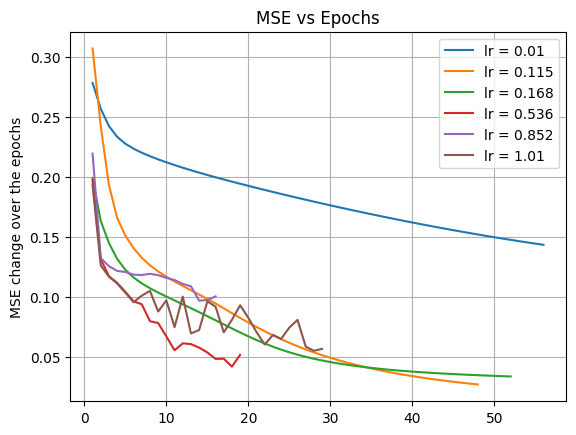

In [10]:
#Part B
LR = [0.01, 0.115, 0.168, 0.536, .852, 1.01]
mseData = []
for lr_ in LR:
    irisMLP = MLP(lr=lr_,shuffle=False, momentum=0, hidden_layer_widths=None)
    accuracy = irisMLP.fit(xTrain, yTrain, epochs=None, validation_percentage=.15).score(xEval,yEval)
    mseData.append(irisMLP.mse)

def draw_the_plot_MSE(mseData, LR):
    for mse, lr_ in zip(mseData, LR):
        x = [i for i in range(1,len(mse)+1)]
        y = mse
        label = 'lr = ' + str(lr_)
        plt.plot(x,y, label=label)
    plt.ylabel("MSE change over the epochs")
    plt.title("MSE vs Epochs")
    plt.legend()
    plt.show()
    plt.grid(True)
draw_the_plot_MSE(mseData, LR)

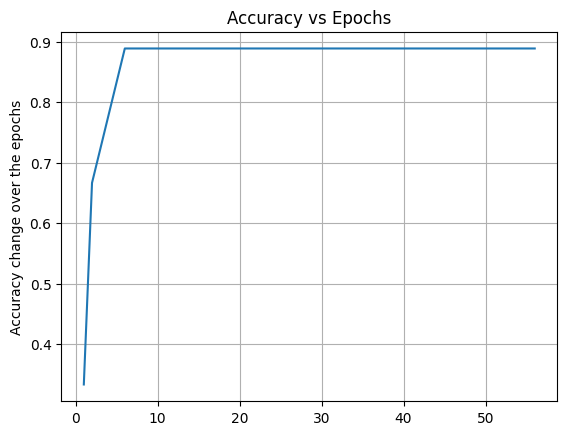

In [12]:
irisMLP = MLP(lr=0.1,shuffle=False, momentum=0, hidden_layer_widths=None)
accuracy = irisMLP.fit(xTrain, yTrain, epochs=None, validation_percentage=.15).score(xEval,yEval)
accuracyList = irisMLP.accuracyList

def draw_the_plot_accuracy(accuracyList):
    x = [i for i in range(1,len(accuracyList)+1)]
    y = accuracyList
    plt.plot(x,y)
    plt.ylabel("Accuracy change over the epochs")
    plt.title("Accuracy vs Epochs")
    plt.show()
draw_the_plot_accuracy(accuracyList)

## 3. (10%) Working with the Vowel Dataset - Learning Rate

Load the Vowel Dataset [Vowel Dataset](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/vowel.arff)

- Use one layer of hidden nodes with the number of hidden nodes being twice the number of inputs.
- Use random 80/20 splits of the data for the training/test set.
- Use a validation set (15% of the training set) taken from the training set for your stopping criteria
- Try some different learning rates (LR). Note that each LR will probably require a different number of epochs to learn. 

- For each LR you test, plot their validation's set MSE over Epochs on the same graph. Graph 4-5 different LRs and make them different enough to see a difference between them.

In general, whenever you are testing a parameter such as LR, # of hidden nodes, etc., test values until no more improvement is found. For example, if 20 hidden nodes did better than 10, you would not stop at 20, but would try 40, etc., until you no longer get improvement.

If you would like you may average the results of multiple initial conditions (e.g. 3) per LR, and that obviously would give more accurate results.

<img src=https://raw.githubusercontent.com/cs472ta/CS472/master/images/backpropagation/backprop_val_set_MSE_vs_epochs.png width=500 height=500  align="left">

In [14]:
data  = arff.loadarff("vowel.arff")
df = pd.DataFrame(data[0])
df  = df.iloc[:,1:]

def one_hot_conversion(df:pd.DataFrame):
    df = df.str.decode('utf-8')
    LE = LabelEncoder()
    OHE= OneHotEncoder(sparse=False)
    X = OHE.fit_transform(LE.fit_transform(df).reshape(-1,1))
    return X

xSex = one_hot_conversion(df['Sex'])
xSpeaker = one_hot_conversion(df['Speaker Number'])
yClass = one_hot_conversion(df['Class'])

xRemain =  df.drop(columns=['Sex', 'Speaker Number', 'Class']).to_numpy()

X = np.concatenate((xRemain, xSpeaker, xSex), axis=1)
y = yClass

xRemain =  df.drop(columns=['Sex', 'Speaker Number', 'Class']).to_numpy()
X = np.concatenate((xRemain, xSpeaker, xSex), axis=1)
y = yClass

xTrain, xTest, yTrain, yTest = train_test_split(X, y, test_size=0.2)

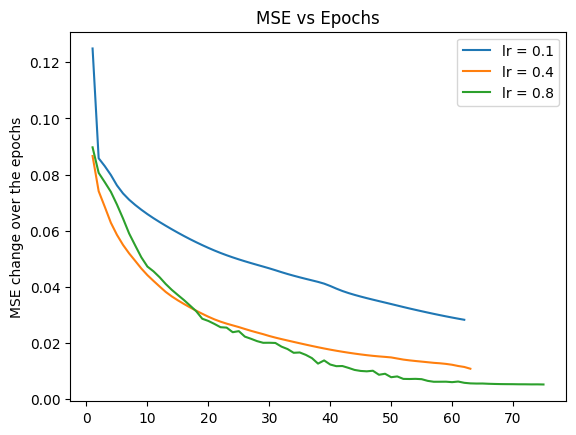

In [15]:
LR = [0.1, 0.4, 0.8]
mseData = []
for lr_ in LR:
    irisMLP = MLP(lr=lr_,shuffle=False, momentum=0, hidden_layer_widths=None)
    accuracy = irisMLP.fit(xTrain, yTrain, epochs=None, validation_percentage=.15).score(xTest,yTest)
    mseData.append(irisMLP.mse)

def draw_the_plot_MSE(mseData, LR):
    for mse, lr_ in zip(mseData, LR):
        x = [i for i in range(1,len(mse)+1)]
        y = mse
        label = 'lr = ' + str(lr_)
        plt.plot(x,y, label=label)
    plt.ylabel("MSE change over the epochs")
    plt.title("MSE vs Epochs")
    plt.legend()
    plt.show()
    plt.grid(True)
draw_the_plot_MSE(mseData, LR)

## 3.1 (5%) Working with the Vowel Dataset - Intuition
- Discuss the effect of varying learning rates. 
- Discuss why the vowel data set might be more difficult than Iris
    - Report both datasets' baseline accuracies and best **test** set accuracies. 
- Consider which of the vowel dataset's given input features you should actually use (Train/test, speaker, gender, ect) and discuss why you chose the ones you did.

Typical backpropagation accuracies for the Vowel data set are above 75%.



*Discuss Intuition here*



## 3.2 (10%) Working with the Vowel Dataset - Hidden Layer Nodes

Using the best LR you discovered, experiment with different numbers of hidden nodes.

- Start with 1 hidden node, then 2, and then double them for each test until you get no more improvement in accuracy. 
- For each number of hidden nodes find the best validation set solution (in terms of validation set MSE).  
- Create one graph with MSE for the training set and validation set on the y-axis and # of hidden nodes on the x-axis.
- Report the final test set accuracy for every # of hidden nodes you experimented on

*Discuss Hidden Layer Nodes here*



## 3.3 (10%) Working with the Vowel Dataset - Momentum

Try some different momentum terms using the best number of hidden nodes and LR from your earlier experiments.

- Create a graph similar to step 3.2, but with momentum on the x-axis and number of epochs until validation set convergence on the y-axis.
- For each momentum term, print the test set accuracy. 
- You are trying to see how much momentum speeds up learning and how it affects accuracy.

*Discuss Momentum here*



## 4.1 (10%) Use the scikit-learn (SK) version of the MLP classifier on the Iris and Vowel data sets.  

You do not need to go through all the steps above, nor graph results. Compare results (accuracy and learning speed) between your version and theirs for some selection of hyper-parameters. Try different hyper-parameters and comment on their effect.

At a minimum, try

- number of hidden nodes and layers
- different activation functions
- learning rate
- regularization and parameters
- momentum (and try nesterov)
- early stopping

In [28]:
# Load sklearn perceptron

# Train on voting dataset

*Record impressions*

## 4.2 (5%) Using the Iris Dataset automatically adjust hyper-parameters using your choice of grid/random search
- Use a grid or random search approach across a reasonable subset of hyper-parameters from the above 
- Report your best accuracy and hyper-parameters. 

In [28]:
# Load sklearn perceptron

# Train on voting dataset

## 5. (Optional 5% Extra credit) For the vowel data set, use the other hyper-parameter approach that you did not use in part 4.2 to find LR, # of hidden nodes, and momentum.  

- Compare and discuss the values found with the ones you found in part 3.


*Discuss findings here*